In [1]:
%%capture
!wget -O data.zip --no-check-certificate https://diskcitylink.pro/arj/vFkdaTX
!unzip data.zip
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from gensim.models.word2vec import Word2Vec

In [2]:
def date_to_data(frame, drop=False, name="event_date", suffix=""):
    assert name in frame, "Нужна колонка с датой"
    date = frame[name].dt

    info = pd.concat([date.days_in_month,
                    date.month,
                    date.quarter,
                    date.dayofyear,
                    date.hour,
                    date.minute], axis=1)

    info.columns = ["days_in_month", "month", "quarter",
                    "dayofyear", "hour", "minute"]

    temp = pd.concat([date.isocalendar(), info], axis=1)

    temp.columns = temp.columns + suffix
    frame = pd.concat([frame, temp], axis=1)
    if drop:
        return frame.drop([name, "year" + suffix], axis=1)
    return frame

In [3]:
all_users = pd.read_csv("01_all_users.csv")
events_log = pd.read_csv("02_events_log.csv")
lk_events_log = pd.read_csv("03_lk_events_log.csv")
is_blocked = pd.read_csv("04_is_blocked.csv")

events_log["event_date"] = pd.to_datetime(events_log["event_date"])
events_log = events_log.sort_values(by=["event_date"]).reset_index(drop=True)

lk_events_log["event_date"] = pd.to_datetime(lk_events_log["event_date"])
lk_events_log = lk_events_log.sort_values(by="event_date").reset_index(drop=True)

events_log = date_to_data(events_log, drop=True, suffix="_events_log")
events_log["contract_id"] = events_log["contract_id"].astype(np.int32)

lk_events_log = date_to_data(lk_events_log, drop=True, suffix="_lk_events_log")
lk_events_log["contract_id"] = lk_events_log["contract_id"].astype(np.int32)

In [4]:
# events_log = events_log.drop(["event_date"], axis=1)
# lk_events_log = lk_events_log.drop(["event_date"], axis=1)

In [5]:
df = all_users.merge(is_blocked, on=["contract_id"], how="left").dropna()
df["contract_id"] = df["contract_id"].astype(np.int32)
df["blocked"] = df["blocked"].astype(np.int32)

In [6]:
events_log_temp = events_log[["contract_id", "event_type"]].groupby("contract_id").agg(list)
events_log_event_type_dict = {j:i for i, j in enumerate(sorted(events_log["event_type"].unique()))}
events_log_temp["event_type_len"] = events_log_temp["event_type"].apply(lambda x: len(x))
events_log_temp["event_type_set"] = events_log_temp["event_type"].apply(lambda x: len(set(x)))
events_log_temp["event_type_diff"] = events_log_temp["event_type_len"] - events_log_temp["event_type_set"]
events_log_temp["event_type"] = events_log_temp["event_type"].apply(lambda x: " ".join(str(events_log_event_type_dict[i]) for i in x))

data = events_log_temp["event_type"].apply(lambda x: x.split()).to_list()
# Training the Word2Vec model
w2v_model = Word2Vec(data, min_count=0, workers=cpu_count(), size=100)
w2v_df_ev = [np.mean([w2v_model.wv[i] for i in j], axis=0) for j in data]
w2v_df_ev = pd.DataFrame(w2v_df_ev, columns=[f"{i}_ev" for i in range(len(w2v_df_ev[0]))])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(events_log_temp["event_type"])
events_log_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
events_log_tfidf.columns +=  "_events_log_tfidf"
events_log_temp = pd.concat([events_log_temp.reset_index(), events_log_tfidf, w2v_df_ev], axis=1)
events_log_temp = events_log_temp.set_index("contract_id")

events_log = events_log.merge(events_log_temp, on="contract_id", how="left")
events_log = events_log.drop(["event_type_x", "event_type_y"], axis=1)
events_log = events_log.drop_duplicates()

In [7]:
lk_events_log_temp = lk_events_log[["contract_id", "name"]].groupby("contract_id").agg(list)
lk_events_log_event_type_dict = {j:i for i, j in enumerate(sorted(lk_events_log["name"].unique()))}
lk_events_log_temp["event_type_len"] = lk_events_log_temp["name"].apply(lambda x: len(x))
lk_events_log_temp["event_type_set"] = lk_events_log_temp["name"].apply(lambda x: len(set(x)))
lk_events_log_temp["event_type_diff"] = lk_events_log_temp["event_type_len"] - lk_events_log_temp["event_type_set"]
lk_events_log_temp["event_type"] = lk_events_log_temp["name"].apply(lambda x: " ".join(str(lk_events_log_event_type_dict[i]) for i in x))

data = lk_events_log_temp["event_type"].apply(lambda x: x.split()).to_list()
# Training the Word2Vec model
w2v_model = Word2Vec(data, min_count=0, workers=cpu_count(), size=100)
w2v_df_lk = [np.mean([w2v_model.wv[i] for i in j], axis=0) for j in data]
w2v_df_lk = pd.DataFrame(w2v_df_lk, columns=[f"{i}_ev" for i in range(len(w2v_df_lk[0]))])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lk_events_log_temp["event_type"])
lk_events_log_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
lk_events_log_tfidf.columns +=  "_lk_events_log_tfidf"
lk_events_log_temp = pd.concat([lk_events_log_temp.reset_index(), lk_events_log_tfidf, w2v_df_lk], axis=1)
lk_events_log_temp = lk_events_log_temp.set_index("contract_id")

lk_events_log = lk_events_log.merge(lk_events_log_temp, on="contract_id", how="left")
lk_events_log = lk_events_log.drop(["name_x", "name_y", "event_type"], axis=1)
lk_events_log = lk_events_log.drop_duplicates()

In [8]:
lk_events_log.columns = lk_events_log.columns + "_lk_events_log"
lk_events_log.columns = ["contract_id", *lk_events_log.columns[1:]]

In [9]:
events_log.columns = events_log.columns + "_events_log"
events_log.columns = ["contract_id", *events_log.columns[1:]]

In [10]:
lk_events_log = lk_events_log.groupby("contract_id").agg(["mean", "median", "min", "max", "var", "std"])
lk_events_log.columns = ["_".join(i) for i in lk_events_log]

In [11]:
events_log = events_log.groupby("contract_id").agg(["mean", "median", "min", "max", "var", "std"])
events_log.columns = ["_".join(i) for i in events_log]

In [12]:
df = df.merge(lk_events_log, on="contract_id", how="left")\
                .merge(events_log, on="contract_id", how="left")

In [13]:
df[df.columns[3:]] = df[df.columns[3:]].astype(np.float32)

In [14]:
df = df.drop(["contract_id"], axis=1).drop_duplicates()

In [15]:
X, y = df.drop(["blocked"], axis=1), df["blocked"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.01,
                                                    random_state=42,
                                                    shuffle=True)

In [16]:
model = CatBoostClassifier(iterations=150,
                           random_state=42,
                           verbose=1,
                           learning_rate=0.1,
                           eval_metric="AUC",
                           task_type="CPU",
                           score_function="Cosine",
                           max_depth=3)

In [17]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	test: 0.7849265	best: 0.7849265 (0)	total: 217ms	remaining: 32.3s
1:	test: 0.8125000	best: 0.8125000 (1)	total: 310ms	remaining: 22.9s
2:	test: 0.8455882	best: 0.8455882 (2)	total: 404ms	remaining: 19.8s
3:	test: 0.8143382	best: 0.8455882 (2)	total: 520ms	remaining: 19s
4:	test: 0.8511029	best: 0.8511029 (4)	total: 601ms	remaining: 17.4s
5:	test: 0.8529412	best: 0.8529412 (5)	total: 681ms	remaining: 16.3s
6:	test: 0.8455882	best: 0.8529412 (5)	total: 765ms	remaining: 15.6s
7:	test: 0.8694853	best: 0.8694853 (7)	total: 843ms	remaining: 15s
8:	test: 0.8805147	best: 0.8805147 (8)	total: 926ms	remaining: 14.5s
9:	test: 0.8915441	best: 0.8915441 (9)	total: 1s	remaining: 14.1s
10:	test: 0.8952206	best: 0.8952206 (10)	total: 1.09s	remaining: 13.8s
11:	test: 0.8915441	best: 0.8952206 (10)	total: 1.17s	remaining: 13.5s
12:	test: 0.8915441	best: 0.8952206 (10)	total: 1.26s	remaining: 13.3s
13:	test: 0.8805147	best: 0.8952206 (10)	total: 1.33s	remaining: 12.9s
14:	test: 0.8731618	best: 0.89522

In [18]:
sorted([i for i in zip(model.feature_importances_, model.feature_names_) if i[0] > 0], reverse=True)

[(5.984306631290949, 'week_lk_events_log_lk_events_log_std'),
 (4.453639363934113, 'dayofyear_lk_events_log_lk_events_log_max'),
 (2.3397685352549646, 'week_lk_events_log_lk_events_log_max'),
 (2.261974446623041, 'quarter_lk_events_log_lk_events_log_var'),
 (2.1060044819022554, '22_lk_events_log_tfidf_lk_events_log_min'),
 (1.9606636694988449, '61_ev_lk_events_log_min'),
 (1.9103267594253421, 'days_in_month_lk_events_log_lk_events_log_mean'),
 (1.869285933435666, 'dayofyear_lk_events_log_lk_events_log_var'),
 (1.5730851241162984, '44_events_log_tfidf_events_log_max'),
 (1.4663519110577559, '41_ev_lk_events_log_median'),
 (1.46568126679422, 'quarter_lk_events_log_lk_events_log_max'),
 (1.2977713997049323, '44_events_log_tfidf_events_log_median'),
 (1.2491181989353735, '94_ev_lk_events_log_max'),
 (1.0860598149258995, '22_lk_events_log_tfidf_lk_events_log_max'),
 (1.0725769874917719, '57_ev_lk_events_log_median'),
 (1.0461228059913852, '17_lk_events_log_tfidf_lk_events_log_max'),
 (1.021

In [19]:
len([i[1] for i in zip(model.feature_importances_, model.feature_names_) if i[0] > 0])

288

In [20]:
golden_features = [i[1] for i in zip(model.feature_importances_, model.feature_names_) if i[0] > 0]

In [21]:
def bootstrap(y_true, y_pred, num, count, random_state=42):
    y_true = y_true.reset_index(drop=True)
    indexes = y_true.index
    results = []
    np.random.seed(random_state)
    for _ in range(num):
        indexes_slice = np.random.choice(indexes, count, replace=False)
        results.append(roc_auc_score(y_true[indexes_slice],
                                     y_pred[indexes_slice]))
    return results

In [22]:
len(y_test)

42

In [23]:
result = bootstrap(y_test, model.predict_proba(X_test)[:, 1], 100, 30, random_state=43)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,
         6.,  3.,  3.,  8., 10.,  6.,  2.,  9., 12.,  5.,  6.,  4.,  8.,
         3.,  7.,  0.,  3.]),
 array([0.91358025, 0.91646091, 0.91934156, 0.92222222, 0.92510288,
        0.92798354, 0.9308642 , 0.93374486, 0.93662551, 0.93950617,
        0.94238683, 0.94526749, 0.94814815, 0.95102881, 0.95390947,
        0.95679012, 0.95967078, 0.96255144, 0.9654321 , 0.96831276,
        0.97119342, 0.97407407, 0.97695473, 0.97983539, 0.98271605,
        0.98559671, 0.98847737, 0.99135802, 0.99423868, 0.99711934,
        1.        ]),
 <a list of 30 Patch objects>)

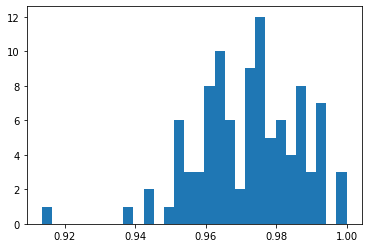

In [24]:
plt.hist(result, bins=30)

In [25]:
test = pd.read_csv("test.csv").drop(["blocked"], axis=1)
source = test["contract_id"].to_list()
test = test.merge(all_users, on="contract_id", how="left").drop_duplicates()
source2 = test["contract_id"].to_list()

In [26]:
test = test.merge(lk_events_log, on="contract_id", how="left")\
                    .merge(events_log, on="contract_id", how="left")\
                    .drop(["contract_id"], axis=1)

In [27]:
test = test.astype(np.float32)

In [28]:
predictions = model.predict_proba(test)[:, 1]

In [29]:
temp = dict(zip(source2, predictions))

In [30]:
result = pd.DataFrame({"contract_id": source,
                       "blocked": [temp[i] for i in source]})

In [31]:
result.to_csv("sub.csv", index=False)

In [32]:
model.save_model("catboost.cbm")